# Preprocessing

This notebook contains the preprocessing required to generate the input data for the retrieval.

In [1]:
import numpy as np
from netCDF4 import Dataset
import glob
from joint_flight.data import hamp, ismar, era5, rasta

No environment variable JOINT_FLIGHT_PATH found. Will look in /home/simonpf/src/joint_flight/joint_flight/..  for the joint flight data.


In [2]:
%rm ../data/input.nc

In [3]:
from netCDF4 import Dataset
raw = False
if raw:
    ds = Dataset("../data/input_raw.nc", "w")
else:
    ds = Dataset("../data/input.nc", "w")

In [4]:
z_ss  = 4
z_ind = np.where(hamp.z > 12e3)[0][0]

## Input data structure

All relevant input data for the forward simulations is stored as variables of the same name in a NetCDF4 file. Using the :code:`parts` package these can read in directly without further plumbing.

In [5]:
profile_index = ds.createDimension("profile_index", hamp.d.size)
altitude      = ds.createDimension("altitude", hamp.z[:z_ind:z_ss].size)

ds.createVariable("sea_surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_u", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_v", "f8", dimensions = ("profile_index",))
ds.createVariable("pressure", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("humidity", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("H2O", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("temperature", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("altitude", "f8", ("profile_index", "altitude"))

<class 'netCDF4._netCDF4.Variable'>
float64 altitude(profile_index, altitude)
unlimited dimensions: 
current shape = (1441, 101)
filling on, default _FillValue of 9.969209968386869e+36 used

## Surface data

The surface data is taken from ERA5.

In [6]:
ds.variables["sea_surface_temperature"][:] = era5.sst
ds.variables["surface_temperature"][:] = era5.skt
ds.variables["wind_u"][:] = era5.u_10
ds.variables["wind_v"][:] = era5.v_10

In [7]:
ds.variables["altitude"][:] = np.broadcast_to(hamp.z.reshape(1, -1), hamp.dbz.shape)[:, :z_ind:z_ss]

In [8]:
from typhon.physics.atmosphere import relative_humidity2vmr
ds.variables["pressure"][:, :] = era5.p
ds.variables["humidity"][:, :] = era5.h2o
ds.variables["H2O"][:, :] = era5.rh
ds.variables["temperature"][:, :] = era5.t

In [9]:
ds.createVariable("O2", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("O3", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("N2", "f8", dimensions = ("profile_index", "altitude"))

<class 'netCDF4._netCDF4.Variable'>
float64 N2(profile_index, altitude)
unlimited dimensions: 
current shape = (1441, 101)
filling on, default _FillValue of 9.969209968386869e+36 used

In [10]:
z_b = np.array([119.26605505,  2118.57516973,   4027.60345297,   5862.87711004,
             7627.64498975,  9297.02869728,  10892.59889357,  12434.63769365,
             13904.25695207, 15290.83137241,  16635.83815029,  17963.99841403,
             19346.95698534, 20750.73842791,  22184.62422791,  23675.44467966,
             25180.02964216, 26780.47609985,  28320.01292605,  29820.7853969 ,
             31494.56521739])
o2  = np.array([ 0.20914768,  0.20917247,  0.20911265,  0.20919441,  0.20921843,
              0.20915963,  0.20914215,  0.20918673,  0.20921144,  0.20916823,
              0.20915074,  0.20918311,  0.20910791,  0.20914558,  0.20908499,
              0.20913025,  0.20910134,  0.20907593,  0.20910521,  0.2091797 ,
              0.20917443])
o2 = np.interp(hamp.z, z_b, o2)
ds.variables["O2"][:, :] = np.broadcast_to(o2.reshape(1, -1), hamp.dbz.shape)[:, :z_ind:z_ss]

o3  = np.array([2.90479819e-08,   3.36389220e-08,   3.56864241e-08,
                3.96190027e-08,   4.38274934e-08,   5.18099738e-08,
                6.50830255e-08,   8.46137019e-08,   1.03927382e-07,
                1.31159885e-07,   2.11682715e-07,   4.91257992e-07,
                1.10672315e-06,   1.70139678e-06,   2.58579126e-06,
                4.01127013e-06,   5.57665027e-06,   7.11467740e-06,
                8.29916685e-06,   9.20149730e-06,   9.63690492e-06])
o3 = np.interp(hamp.z, z_b, o3)
ds.variables["O3"][:, :] = np.broadcast_to(o3.reshape(1, -1), hamp.dbz.shape)[:, :z_ind:z_ss]

n2 = np.array([0.78143085,  0.78164177,  0.78123672,  0.78189026,  0.78169185,
               0.78155673,  0.78151964,  0.78156695,  0.78156223,  0.78157601,
               0.78164542,  0.78170006,  0.78154427,  0.78127151,  0.78165497,
               0.78161547,  0.7815775 ,  0.78152597,  0.78153412,  0.78159145,
               0.78158467])
n2 = np.interp(hamp.z, z_b, n2)
ds.variables["N2"][:, :] = np.broadcast_to(n2.reshape(1, -1), hamp.dbz.shape)[:, :z_ind:z_ss]

### Hamp radar

The HAMP radar reflectivities are averaged to a resolution of 120 meters. Ground clutter and the reflection of the FAAM aircraft are removed.

In [11]:
rasta.time

masked_array(data=[35400.305, 35401.055, 35401.805, ..., 37258.055,
                   37258.805, 37259.555],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [12]:
hamp.time

masked_array(data=[35490., 35491., 35492., ..., 36928., 36929., 36930.],
             mask=False,
       fill_value=1e+20)

In [13]:
ismar.time

masked_array(data=[35329.51 , 35333.188, 35336.863, 35340.523, 35344.188,
                   35347.86 , 35351.53 , 35355.21 , 35358.887, 35362.566,
                   35366.242, 35369.9  , 35373.562, 35377.215, 35380.895,
                   35384.566, 35388.23 , 35391.914, 35395.59 , 35399.26 ,
                   35402.945, 35406.63 , 35410.293, 35413.977, 35417.645,
                   35421.305, 35424.97 , 35428.63 , 35432.29 , 35435.965,
                   35439.637, 35443.3  , 35446.977, 35450.633, 35454.31 ,
                   35457.973, 35461.656, 35465.348, 35469.016, 35472.7  ,
                   35476.367, 35480.027, 35483.703, 35487.38 , 35491.047,
                   35494.707, 35498.36 , 35502.04 , 35505.715, 35509.395,
                   35513.082, 35516.754, 35520.414, 35524.094, 35527.746,
                   35531.4  , 35535.066, 35538.727, 35542.402, 35546.06 ,
                   35549.742, 35553.406, 35557.086, 35560.75 , 35564.426,
                   35568.1  , 35571.78

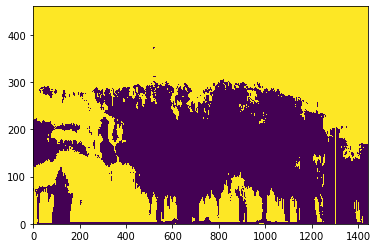

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pcolormesh(hamp.dbz.mask.T)

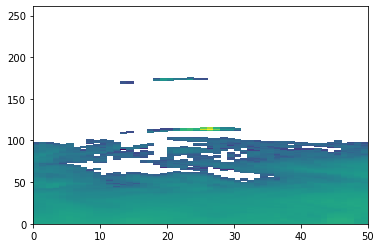

In [15]:
plt.pcolormesh(hamp.dbz[500 : 550, 200:].T)

In [16]:
from mcrf.sensors import hamp_radar

# Fill gaps
dbz = np.copy(hamp.dbz)
gaps = np.where(np.all(hamp.dbz.mask, axis = 1))
for i_g in gaps:
    dbz[i_g, :] = 0.5 * (dbz[i_g - 1, :] + dbz[i_g + 1, :])
    
yz = 10 ** (dbz / 10)
yz.shape
yz_z = np.broadcast_to(hamp.z.reshape(1, -1), yz.shape)
bins = hamp_radar.range_bins

yz_r = np.zeros((yz.shape[0], hamp_radar.range_bins.size - 1))
for i in range(yz.shape[0]):
    y = yz[i, :]
    z = hamp.z
    cts, _ = np.histogram(z, bins=bins)
    yt, _ = np.histogram(z, weights=y, bins=bins)
    yz_r[i, cts == 0.0] = -30.0
    yz_r[i, :] = np.maximum(10.0 * np.log10(yt / cts), -30.0)
    
dz = bins[:-1].reshape(1, -1) - np.maximum(hamp.zs.reshape(-1, 1), 0.0)



z = 0.5 * (bins[1:] + bins[:-1])
yz_r_z = np.broadcast_to(z.reshape(1, -1), yz_r.shape)

# Interpolate times to hamp path
t_falcon = np.interp(hamp.d, rasta.d, rasta.time)
i_falcon = np.argmin(np.abs(t_falcon - hamp.time))
z_falcon = np.interp(hamp.d, rasta.d, rasta.altitude)
j_falcon = np.argmin(np.abs(z - z_falcon[i_falcon]))

t_faam = np.interp(hamp.d, ismar.d, ismar.time)
i_faam = np.argmin(np.abs(t_faam - hamp.time))
z_faam = np.interp(hamp.d, ismar.d, ismar.altitude)
j_faam = np.argmin(np.abs(z - z_faam[i_falcon]))


# Remove ground clutter
yz_r[dz < 250] = -30

nedt = np.zeros(yz_r.shape)
nedt[dz < 250] = 1e12

i_start = i_faam - 20
i_end = i_faam + 20
j_start = j_faam - 2
j_end = j_faam + 2
if not raw:
    yz_r[i_start : i_end, j_start : j_end] = -30
nedt[i_start : i_end, j_start : j_end] = 1e12


i_start = i_falcon - 20 
i_end = i_falcon + 20 
j_start = j_falcon - 2
j_end = j_falcon + 2
if not raw:
    yz_r[i_start : i_end, j_start : j_end] = -30
nedt[i_start : i_end, j_start : j_end] = 1e12

print(i_faam, j_faam)
print(i_falcon, j_falcon)

Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so
530 46
523 55


/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


In [17]:
ds.createDimension("y_hamp_radar_bins", size = hamp_radar.range_bins.size - 1)
ds.createVariable("y_hamp_radar", "f8", dimensions = ("profile_index", "y_hamp_radar_bins"))
ds.variables["y_hamp_radar"][:, :] = yz_r
ds.createVariable("y_hamp_radar_nedt", "f8", dimensions = ("profile_index", "y_hamp_radar_bins"))
ds.variables["y_hamp_radar_nedt"][:, :] = nedt

In [18]:
yz_r.shape

(1441, 59)

### Hamp radiometer

In [19]:
ds.createDimension("hamp_channels", size = 26)
ds.createVariable("y_hamp_passive", "f8", dimensions = ("profile_index", "hamp_channels"))
ds.createVariable("y_hamp_passive_nedt", "f8", dimensions = ("profile_index", "hamp_channels"))

<class 'netCDF4._netCDF4.Variable'>
float64 y_hamp_passive_nedt(profile_index, hamp_channels)
unlimited dimensions: 
current shape = (1441, 26)
filling on, default _FillValue of 9.969209968386869e+36 used

In [20]:
# Fill gaps in data with NN interpolation.
y_hamp_passive = np.zeros(hamp.bt.shape)
for i in range(y_hamp_passive.shape[1]):
    mask = np.logical_not(hamp.bt.mask[:, i])
    y_hamp_passive[mask, i] = hamp.bt[mask, i]
    for j in np.where(hamp.bt.mask[:, i])[0]:
        j_ind = np.argmin(np.abs(j - np.where(mask)[0]))
        j_ind = np.where(mask)[0][j_ind]
        y_hamp_passive[j, i] = hamp.bt[j_ind, i]

In [21]:
ds.variables["y_hamp_passive"][:, :] = y_hamp_passive

In [22]:
from scipy.signal import convolve

k = np.ones(5) / 5.0
land = hamp.zs > 0.0
land = convolve(land, k, "same")
surface_inds = np.where(land > 0.0)[0]
nedts = np.zeros((hamp.d.size, 26))
surface_channels = np.arange(19)
for i in surface_channels:
    nedts[surface_inds, i] = 1e6

In [23]:
np.where?

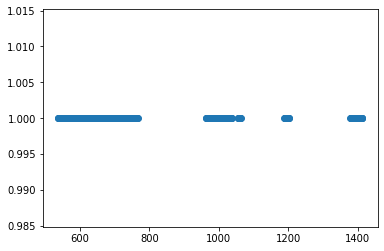

In [24]:
plt.scatter(surface_inds, np.ones(surface_inds.size))

In [25]:
ds.variables["y_hamp_passive_nedt"][:, :] = nedts

### ISMAR radiometer

In [26]:
ismar_tbs_i = np.zeros((hamp.d.size, 21))
ismar_nedt_i = np.zeros((hamp.d.size, 21))
for i in range(21):
    ismar_tbs_i[:, i] = np.interp(hamp.d, ismar.d, ismar.tbs[:, i])
    ismar_nedt_i[:, i] = np.interp(hamp.d, ismar.d, ismar.nedt[:, i])

For the ISMAR radiomenter not all channels contain useful information. For the retrieval
only the following channels will be used:

| Frequency [GHz] | Number of channels| Original channel indices  |
|-----------------|-------------------|---------------------------|
| 118             |         5         |            0, 1, 2, 3, 4  |
| 243             |         1         |            mean of 5, 6   |
| 325             |         3         |                 7, 8, 9   |
| 664             |         1         |                 17        |


In [27]:
y_ismar = np.zeros((hamp.d.size, 10))
y_ismar_nedt = np.zeros((hamp.d.size, 10))

# 118 GHz
y_ismar[:, :5] = ismar_tbs_i[:, :5]
y_ismar_nedt[:, :5] = ismar_nedt_i[:, :5]

# 243 GHz
y_ismar[:, 5] = np.mean(ismar_tbs_i[:, 5 : 7], axis = 1)
y_ismar_nedt[:, 5] = np.sqrt(np.sum(ismar_nedt_i[:, 5 : 7] ** 2, axis = 1) / 2.0)

# 325 GHz
y_ismar[:, 6 : 9] = ismar_tbs_i[:, 7 : 10]
y_ismar_nedt[:, 6 : 9] = ismar_nedt_i[:, 7 : 10]

# 664 GHz
y_ismar[:, 9] = ismar_tbs_i[:, 17]
y_ismar_nedt[:, 9] = ismar_nedt_i[:, 17]

# Disable surface sensitive channels
surface_channels = np.arange(5)
for i in surface_channels:
    y_ismar_nedt[surface_inds, i] = 1e6

In [28]:
ds.createDimension("ismar_channels", size = 10)
ds.createVariable("y_ismar", "f8", dimensions = ("profile_index", "ismar_channels"))
ds.createVariable("y_ismar_nedt", "f8", dimensions = ("profile_index", "ismar_channels"))
ds["y_ismar"][:] = y_ismar
ds["y_ismar_nedt"][:] = y_ismar_nedt

In [29]:
ds.close()

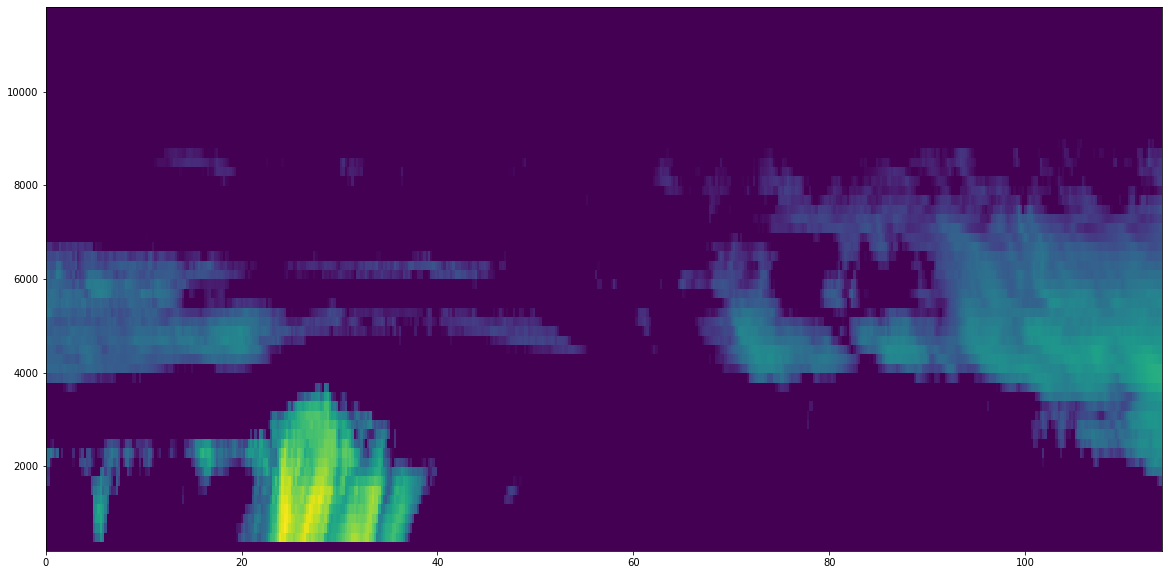

In [30]:
plt.figure(figsize = (20, 10))
plt.pcolormesh(hamp.d[:500], z, yz_r[:500, :].T)

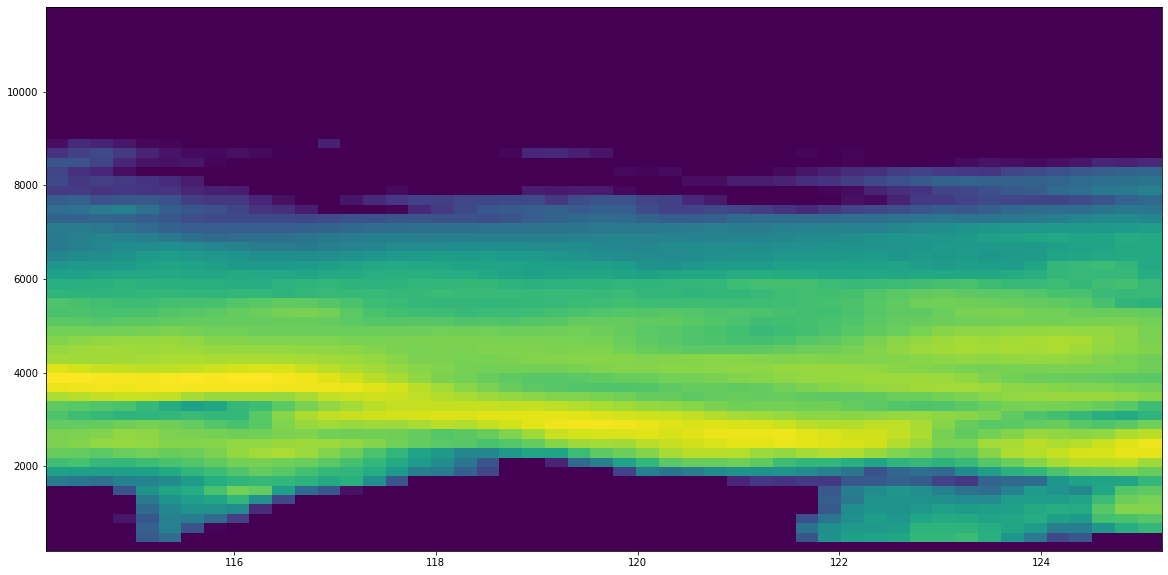

In [31]:
plt.figure(figsize = (20, 10))
plt.pcolormesh(hamp.d[500:550], z, yz_r[500:550, :].T)

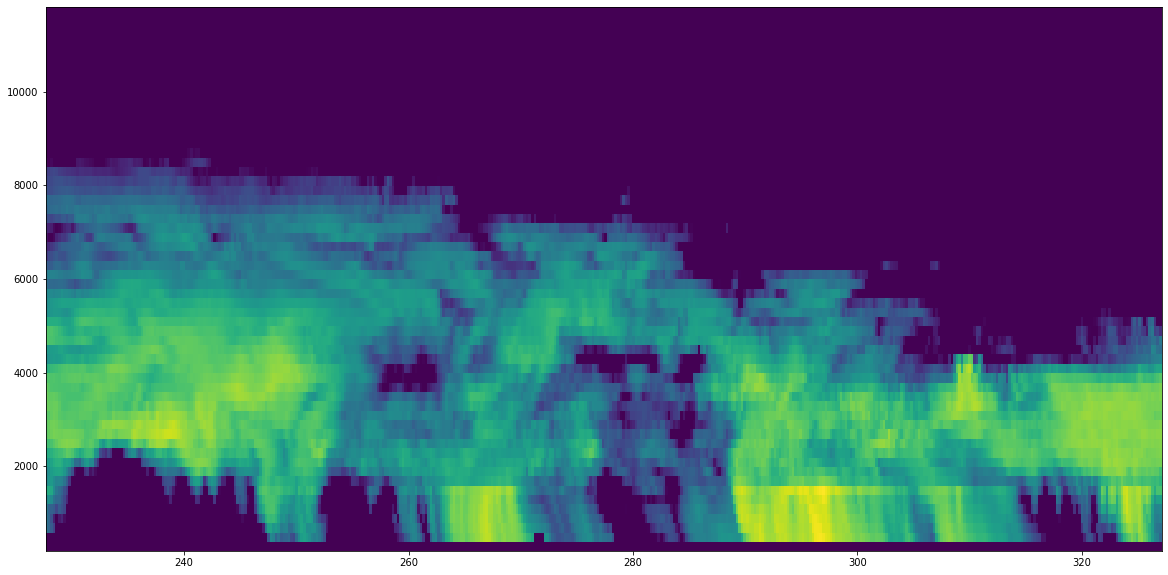

In [32]:
plt.figure(figsize = (20, 10))
plt.pcolormesh(hamp.d[1000:1500], z, yz_r[1000:1500, :].T)